[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/googlecolab/colabtools/blob/master/notebooks/colab-github-demo.ipynb)


# Solution to the Exercise of Chapter One


The first chapter is basicly a short introduction to some core concepts. The categorization of ML and some example applications and some other concepts like parametric&non-parametric, overfit, model selection and no free lunch theorem. My personal note for this chapter see [here](https://www.notion.so/luxxxlucy/Notes-of-Chap-1-MLaPP-8dffb60037a94851946735e1dfe6f50a).

This chapter, since it is only introduction, has only three exercise question and all are about K-nearest neighbour (KNN). The aim of these three exercise, from I see, is just to confirm with some concepts delivered through the text.

First of all, to make it faster, I use only the first 1000 data, to speed up.


## __Exercise 1.1__ KNN classifier on shuffled MNIST data




__Question__:

Run mnist1NNdemo and verify that the misclassification rate (on the first 1000 test cases) of MNIST of a 1-NN classifier is 3.8%. (If you run it all on all 10,000 test cases, the error rate is 3.09%.) Modify the code so that you first randomly permute the features (columns of the training and test design matrices), as in shuffledDigitsDemo, and then apply the classifier. Verify that the error rate is not changed.

(*I use python (in particular the sci-kit tool) anyway*)

__Answer__:

The error rate does not change
This result is not surprsing. The error rate does not change even we change the order of feature, simply because the model we use does not utilize the order information at all. The euclidean distance has no emphasis on the order of features.


In [1]:
import numpy as np
from sklearn.datasets import fetch_openml
from sklearn.neighbors import KNeighborsClassifier as KNN
from sklearn.metrics import accuracy_score

In [2]:
# download the mnist data
mnist = fetch_openml('mnist_784', version=1, return_X_y=True)

In [3]:
# data loading

# N_train = 60000
print("for speed up, I only use the first 1000 samples")
N_train = 1000 # speed up

np.random.seed(0)
X,y = mnist

X_train = X[:N_train]
X_test = X[60000:]
y_train = y[:N_train]
y_test = y[60000:]

for speed up, I only use the first 1000 samples


In [4]:
# fit the model
knn = KNN(n_neighbors=1,n_jobs=-1)
knn.fit(X_train, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=-1, n_neighbors=1, p=2,
                     weights='uniform')

In [5]:
%%timeit -n 1 -r 1
# track the execution time, change the loop time if you want

# test the accuracy
print("starting predicting. But finding nearest neighbour is not so quick (if you use the full training set) ")
y_pred = knn.predict(X_test)
test_error_rate = 1 - accuracy_score(y_pred, y_test)
print("the test error(inaccuracy) is: ",test_error_rate)

starting predicting. But finding nearest neighbour is not so quick (if you use the full training set) 
the test error(inaccuracy) is:  0.131
6.21 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


In [6]:
%%timeit -n 1 -r 1

# random shuffle for feature
feature_ind = np.random.permutation(X.shape[1])
X_train_shuffle = X_train[:, feature_ind]
X_test_shuffle = X_test[:, feature_ind]
knn_shuffle = KNN(n_neighbors=1, n_jobs=-1)
knn_shuffle.fit(X_train_shuffle, y_train)
y_pred_shuffle = knn_shuffle.predict(X_test_shuffle)
print("starting predicting. But finding nearest neighbour is not so quick (if you use the full training set)")
test_shuffle_error_rate = 1 - accuracy_score(y_pred_shuffle, y_test)
print("the test error(inaccuracy) of the permutated features is: ", test_shuffle_error_rate)  # equals the above result

starting predicting. But finding nearest neighbour is not so quick (if you use the full training set)
the test error(inaccuracy) of the permutated features is:  0.131
7.71 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)



## __Exercise 1.2__ Approximate KNN classifiers

__Question__:
Use the Matlab/C++ code at http://people.cs.ubc.ca/~mariusm/index.php/FLANN/FLANN to per- form approximate nearest neighbor search, and combine it with mnist1NNdemo to classify the MNIST data set. How much speedup do you get, and what is the drop (if any) in accuracy?

__Answer__:

A small drop in accuracy: 13% -> 14\~15%

A huge improvement on speed: 5\~6s -> 0.8\~1ms

In [7]:
print("first get the FLANN for python")
!pip install pyflann-py3

first get the FLANN for python


In [8]:
%%timeit -n 1 -r 1

from pyflann import FLANN



flann = FLANN()

X_train_float32 = X_train.copy().astype(np.float32)
X_test_float32 = X_test.copy().astype(np.float32)
# the flann only takes float32 so it needs first a casting!

nearest_neighbours,dists = flann.nn(X_train_float32,X_test_float32,1,algorithm="kmeans",
branching=32, iterations=7, checks=16)

def classify(neighbours_array, labels):
    from collections import defaultdict
    results = []
    if len(neighbours_array.shape) ==1:
        # only 1 neighbour
        neighbours_array = np.expand_dims(neighbours_array, axis=1)
    print(neighbours_array.shape)
    for i,neighbours in enumerate(neighbours_array):
        temp_dic = defaultdict(int)
        for n in neighbours:
            temp_dic[ labels[n] ]+=1
        result = max( temp_dic.items(),key= lambda x:x[1])[0]
        results.append(result)
    
    return results

y_pred_flann = classify(nearest_neighbours,y_train)
test_flann_error_rate = 1 - accuracy_score(y_pred_flann, y_test)
print("the test error(inaccuracy) of the permutated features is: ", test_flann_error_rate)  # equals the above result

(10000, 1)
the test error(inaccuracy) of the permutated features is:  0.1412
1.2 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)



## __Exercise 1.3__ CV (Cross Validation) for KNN

__Question__

Use knnClassifyDemo to plot the CV estimate of the misclassification rate on the test set. Compare this to Figure 1.21(a). Discuss the similarities and differences to the test error rate.

__Answer__

(too speed up I used the flann to speed up, but the trend is alike. You can try your self)

Not identical but similar. The general trend is that the train error is always lower, and test&CV error is alike.

When K is small, we overfit (good on train set but bad on test set). And as K becomes larger, the error rates in general also grows.

The major difference of this plot and the Figure 1.21(a) is that, in Figure 1.21(a), when K=1 the test error is extremely large, yet in this plot, even in K=1, the error is not so large. This indicate that in MNIST task, the overfir of the K=1 of KNN is not so serious. 

In [9]:
def flann_knn_classify(train_data,train_label,K,test_data):
    from pyflann import FLANN
    
    def classify(neighbours_array, labels):
        from collections import defaultdict
        results = []
        if len(neighbours_array.shape) == 1:
            # only 1 neighbour
            neighbours_array = np.expand_dims(neighbours_array, axis=1)
        for i,neighbours in enumerate(neighbours_array):
            temp_dic = defaultdict(int)
            for n in neighbours:
                temp_dic[ labels[n] ]+=1
            result = max( temp_dic.items(),key= lambda x:x[1])[0]
            results.append(result)
        return results

    flann = FLANN()
    t = np.float32
    train_data, test_data = train_data.astype(t), test_data.astype(t)
    nearest_neighbours,dists = flann.nn(train_data,test_data,K,algorithm="kmeans", branching=32, iterations=7, checks=16)
    y_pred_flann = classify(nearest_neighbours,train_label)
    return y_pred_flann

In [10]:
# lets do k-fold validation and compare the test error!

from sklearn.model_selection import KFold

n_fold = 5
use_flann = True
N_train = X_train.shape[0]
kf = KFold(n_splits=n_fold)

k_min, k_max, step= 1, 100, 5
ks = np.arange(k_min, k_max + 1, step=step)
cv_errors = []
test_errors = []
train_errors = []

from tqdm import tqdm_notebook as tqdm

for k in tqdm(ks):
    temp_errors=[]
    for train_index, test_index in kf.split(X_train):
        X_train_cv, X_vali_cv = X_train[train_index], X_train[test_index]
        y_train_cv, y_vali_cv = y_train[train_index], y_train[test_index]
        
        if use_flann:
            cv_model_pred = flann_knn_classify(X_train_cv, y_train_cv, k, X_vali_cv)
            
        else:
            cv_model = KNN(n_neighbors=k, n_jobs=-1)
            cv_model.fit(X_train_cv, y_train_cv)
            cv_model_pred = cv_model.predict(X_vali_cv)
        temp_errors.append(1 - accuracy_score(cv_model_pred, y_vali_cv))
#         print(cv_model_pred)
#         print(y_vali_cv)
    cv_errors.append(sum(temp_errors) / n_fold)

    if use_flann:
        whole_model_pred = flann_knn_classify(X_train, y_train, k, X_test)
    else:
        whole_model = KNN(n_neighbors=k, n_jobs=-1)
        whole_model.fit(X_train,y_train)
        whole_model_pred = whole_model.predict(X_test)

    test_errors.append( 1 - accuracy_score(whole_model_pred, y_test))
    
    if use_flann:
        whole_model_pred = flann_knn_classify(X_train, y_train, k, X_train)

    else:
        whole_model = KNN(n_neighbors=k, n_jobs=-1)
        whole_model.fit(X_train,y_train)
        whole_model_pred = whole_model.predict(X_train)

    train_errors.append( 1 - accuracy_score(whole_model_pred, y_train))


                     

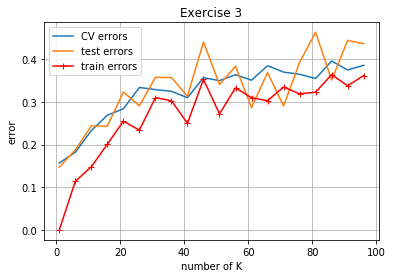

In [13]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import numpy as np

# Data for plotting
t = np.arange(0.0, 2.0, 0.01)
s = 1 + np.sin(2 * np.pi * t)

fig, ax = plt.subplots()
ax.plot(ks, cv_errors, label="CV errors")
ax.plot(ks, test_errors, label="test errors")
ax.plot(ks, train_errors, "r-+",label="train errors")

ax.set(xlabel='number of K', ylabel='error',
       title='Exercise 3')
ax.legend()
ax.grid()

# fig.savefig("test.png")
plt.show()